In this exercise we will decode orientation using data collected for the Cognitive Neuroscience module in 2016.  The subject performed an implementation of the task by Harrison and Tong (2009). 

##### Load data

First we load the data files.

In [51]:
import os,json,glob
import numpy,pandas
import nibabel
import sklearn.multiclass
from sklearn.svm import SVC
import sklearn.metrics
import sklearn.model_selection
import sklearn.preprocessing
import scipy.stats
import random
import seaborn 
%matplotlib inline
import matplotlib.pyplot as plt


datadir='orientation_data'

print('using data from %s'%datadir)

def get_orientation_data(datadir):
    groups=['All','V1','V2','V3']
    data={}
    for g in groups:
        yfile=os.path.join(datadir,'%s_groups.txt'%g)
        xfile=os.path.join(datadir,'%s_instances.txt'%g)
        data[g]={'X':numpy.loadtxt(xfile),'Y':numpy.loadtxt(yfile)}
    return data

odata=get_orientation_data(datadir)

using data from orientation_data


#### Describe and visualize the data

Here we will focus on the signal from V1 voxels.

151 trials
120 V1 voxels


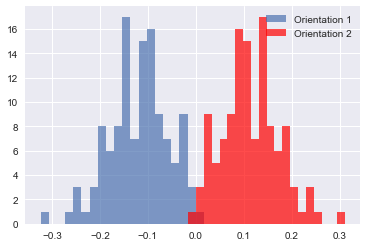

In [57]:
v='V1'
ntrials,nvox=odata[v]['X'].shape
print(ntrials,'trials')
print(nvox,v,'voxels')
# make a pandas data frame to make manipulation easier
df=pandas.DataFrame(odata[v]['X'])
df['label']=odata[v]['Y']
mask=df.label==1
del df['label']
df1=df[mask]
df2=df[~mask]
roimean=df.mean()
_=plt.hist(df1.mean(),20,alpha=0.7)
_=plt.hist(df2.mean(),20,color='red',alpha=0.7)
plt.legend(['Orientation 1','Orientation 2'])


(120,)

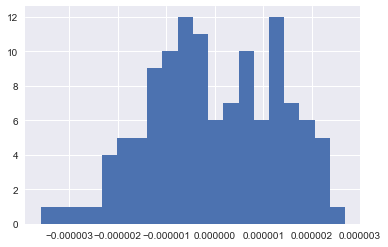

In [59]:
plt.hist(roimean,20)
roimean.shape

Fit a simple classifier using balanced 8-fold crossvalidation

In [9]:
def run_classifier(odata, shuffle=False,nfolds=8,C=1,scale=True):
    groups=['All','V1','V2','V3']
    acc={}
    for g in groups:
        features=odata[g]['X']
        if scale:
            features=sklearn.preprocessing.scale(features)
        labels=odata[g]['Y'].copy()
        if shuffle:
            numpy.random.shuffle(labels)
        skf = sklearn.model_selection.StratifiedKFold(8)
        pred=numpy.zeros(labels.shape[0])
        for train, test in skf.split(features,labels):
            clf=sklearn.svm.SVC(C=C)
            clf.fit(features[train,:],labels[train])
            pred[test]=clf.predict(features[test,:])
        acc[g]=sklearn.metrics.accuracy_score(labels, pred)
    return acc

C=10

acc=run_classifier(odata,C=C)
print(acc)

{'All': 0.66887417218543044, 'V1': 0.64238410596026485, 'V2': 0.61589403973509937, 'V3': 0.6887417218543046}


Now let's see if this is better than we would predict by chance.  we will do this by randomly shuffling the labels and recording the accuracy score for each random run, and then comparing our actual score to that null distribution.  

NOTE: This will take a few minutes to complete.

In [11]:
groups=['All','V1','V2','V3']
nruns=1000
rand_acc=numpy.zeros((nruns,4))
for r in range(nruns):
    tmp=run_classifier(odata,shuffle=True,C=C)
    rand_acc[r,:]=[tmp['All'],tmp['V1'],tmp['V2'],tmp['V3']]

In [27]:
mean_acc=numpy.mean(rand_acc,0)

for i in range(len(groups)):
    print('%s voxels: %0.3f (p=%0.3f)'%(groups[i],acc[groups[i]],
                    1-scipy.stats.percentileofscore(rand_acc[i,:],acc[groups[i]])/100.))


All voxels: 0.669 (p=0.000)
V1 voxels: 0.642 (p=0.000)
V2 voxels: 0.616 (p=0.000)
V3 voxels: 0.689 (p=0.000)


__Exercise__: Compare our results to those reported by Harrison & Tong.  How do they compare, and why do you think they might be different?